In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import subprocess
import os
import shutil
import pandas as pd
import matplotlib.animation as animation
import time
import pylab as pl
from IPython import display
import seaborn as sns
import cv2
from scipy import interpolate
from os import listdir
from os.path import isfile, join
from IPython.display import display, Markdown
import multiprocessing
from multiprocessing import Pool, freeze_support, cpu_count
import math
#from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D
import matplotlib.collections as mcol
import matplotlib.legend_handler
import re
import glob
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch

#import athena_rad
import pickle
from matplotlib.collections import LineCollection
import seaborn as sns
import fnmatch

In [2]:
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 27
mpl.rcParams['ytick.labelsize'] = 27

mpl.rcParams['xtick.major.size'] = 18 #+2 from previous
mpl.rcParams['xtick.minor.size'] = 12 #+4 from previous
mpl.rcParams['ytick.major.size'] = 18 #+4 from previous
mpl.rcParams['ytick.minor.size'] = 12 #+4 from previous

mpl.rcParams['axes.grid.which'] = 'major'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.alpha'] = 0.5
mpl.rcParams['axes.grid.which'] = 'minor'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.alpha'] = 0.5

mpl.rcParams['legend.fontsize'] = 22

mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

np.set_printoptions(precision=3)

In [3]:
''' C O N S T A N T S '''
# Mass of Hydrogen (grams)
mH = 1.6735575*10**-24
# Mean particle mass (grams)
mu = 2.33
# Gamma
gamma = 1.4
# Boltzmann constant (erg K-1)
kB = 1.380649*10**-16
# Gravitational constant (dyn cm2 g-2)
G = 6.67430*10**-8
# Mass of star (grams per solar mass)
M_sol = 1.98847*10**33
# AU to cm
AU = 1.4959787069100*10**13
# seconds in a year
yr = 3.155693*10**7 # seconds
# Mass of Earth (grams per Earth mass)
M_earth = 5.97237*10**27
# Stefan-Boltzman constant
sig_sb = 5.6704*10**-5 #erg cm-2 s-1 K-4 
# Solar radius
R_sol = 6.957*10**10 #cm
# Stefan-Boltzmann constant
#sb = 5.67*10**-8 #W m-2 K-4
sb = 5.67*10**-5 #erg cm-2 s-1 K-4
# Earth's radius
R_earth = 6.378*10**8 #cm


In [4]:
"""
Read Athena++ output data files.
"""

# Python modules
import re
import struct
import sys
import warnings
from io import open  # Consistent binary I/O from Python 2 and 3

# Other Python modules
import numpy as np

check_nan_flag = False


# ========================================================================================

def check_nan(data):
    """Check input NumPy array for the presence of any NaN entries"""
    if np.isnan(data).any():
        raise FloatingPointError("NaN encountered")
    return


# ========================================================================================

def error_dat(filename, **kwargs):
    """Wrapper to np.loadtxt() for applying optional checks used in regression tests"""
    data = np.loadtxt(filename,
                      dtype=np.float64,
                      ndmin=2,  # prevent NumPy from squeezing singleton dimensions
                      **kwargs)
    if check_nan_flag:
        check_nan(data)
    return data


# ========================================================================================

def hst(filename, raw=False):
    """Read .hst files and return dict of 1D arrays.
    Keyword arguments:
    raw -- if True, do not prune file to remove stale data from prev runs (default False)
    """

    # Read data
    with open(filename, 'r') as data_file:
        # Find header
        header_found = False
        multiple_headers = False
        header_location = None
        line = data_file.readline()
        while len(line) > 0:
            if line == '# Athena++ history data\n':
                if header_found:
                    multiple_headers = True
                else:
                    header_found = True
                header_location = data_file.tell()
            line = data_file.readline()
        if multiple_headers:
            warnings.warn('Multiple headers found; using most recent data', AthenaWarning)
        if header_location is None:
            raise AthenaError('No header found')

        # Parse header
        data_file.seek(header_location)
        header = data_file.readline()
        data_names = re.findall(r'\[\d+\]=(\S+)', header)
        if len(data_names) == 0:
            raise AthenaError('Header could not be parsed')

        # Prepare dictionary of results
        data = {}
        for name in data_names:
            data[name] = []

        # Read data
        for line in data_file:
            for name, val in zip(data_names, line.split()):
                data[name].append(float(val))

    # Finalize data
    for key, val in data.items():
        data[key] = np.array(val)
    if not raw:
        if data_names[0] != 'time':
            raise AthenaError('Cannot remove spurious data because time column could not'
                              + ' be identified')
        branches_removed = False
        while not branches_removed:
            branches_removed = True
            for n in range(1, len(data['time'])):
                if data['time'][n] <= data['time'][n-1]:
                    branch_index = np.where(data['time'][:n] >= data['time'][n])[0][0]
                    for key, val in data.items():
                        data[key] = np.concatenate((val[:branch_index], val[n:]))
                    branches_removed = False
                    break
        if check_nan_flag:
            for key, val in data.items():
                check_nan(val)
    return data


# ========================================================================================

def tab(filename, raw=False, dimensions=None):
    """Read .tab files and return dict or array.
    Keyword arguments:
    raw -- if True, do not parse the header to figure out key names (default False)
    """

    # Check for valid number of dimensions
    if raw and not (dimensions == 1 or dimensions == 2 or dimensions == 3):
        raise AthenaError('Improper number of dimensions')
    if not raw and dimensions is not None:
        warnings.warn('Ignoring specified number of dimensions', AthenaWarning)

    # Parse header
    if not raw:
        data_dict = {}
        with open(filename, 'r') as data_file:
            line = data_file.readline()
            attributes = re.search(r'time=(\S+)\s+cycle=(\S+)\s+variables=(\S+)', line)
            line = data_file.readline()
            headings = line.split()[1:]
        data_dict['time'] = float(attributes.group(1))
        data_dict['cycle'] = int(attributes.group(2))
        data_dict['variables'] = attributes.group(3)
        if headings[0] == 'i' and headings[2] == 'j' and headings[4] == 'k':
            headings = headings[1:2] + headings[3:4] + headings[5:]
            dimensions = 3
        elif ((headings[0] == 'i' and headings[2] == 'j')
              or (headings[0] == 'i' and headings[2] == 'k')
              or (headings[0] == 'j' and headings[2] == 'k')):
            headings = headings[1:2] + headings[3:]
            dimensions = 2
        elif headings[0] == 'i' or headings[0] == 'j' or headings[0] == 'k':
            headings = headings[1:]
            dimensions = 1
        else:
            raise AthenaError('Could not parse header')

    # Go through lines
    data_array = []
    with open(filename, 'r') as data_file:
        first_line = True
        for line in data_file:
            # Skip comments
            if line.split()[0][0] == '#':
                continue

            # Extract cell indices
            vals = line.split()
            if first_line:
                i_min = i_max = int(vals[0])
                if dimensions == 2 or dimensions == 3:
                    j_min = j_max = int(vals[2])
                if dimensions == 3:
                    k_min = k_max = int(vals[4])
                num_entries = len(vals) - dimensions
                first_line = False
            else:
                i_max = max(i_max, int(vals[0]))
                if dimensions == 2 or dimensions == 3:
                    j_max = max(j_max, int(vals[2]))
                if dimensions == 3:
                    k_max = max(k_max, int(vals[4]))

            # Extract cell values
            if dimensions == 1:
                vals = vals[1:]
            if dimensions == 2:
                vals = vals[1:2] + vals[3:]
            if dimensions == 3:
                vals = vals[1:2] + vals[3:4] + vals[5:]
            data_array.append([float(val) for val in vals])

    # Reshape array based on number of dimensions
    if dimensions == 1:
        array_shape = (i_max-i_min+1, num_entries)
        array_transpose = (1, 0)
    if dimensions == 2:
        array_shape = (j_max-j_min+1, i_max-i_min+1, num_entries)
        array_transpose = (2, 0, 1)
    if dimensions == 3:
        array_shape = (k_max-k_min+1, j_max-j_min+1, i_max-i_min+1, num_entries)
        array_transpose = (3, 0, 1, 2)
    data_array = np.transpose(np.reshape(data_array, array_shape), array_transpose)

    # Finalize data
    if raw:
        if check_nan_flag:
            check_nan(data_array)
        return data_array
    else:
        for n, heading in enumerate(headings):
            if check_nan_flag:
                check_nan(data_array[n, ...])
            data_dict[heading] = data_array[n, ...]
        return data_dict


# ========================================================================================

def vtk(filename):
    """Read .vtk files and return dict of arrays of data."""

    # Read raw data
    with open(filename, 'rb') as data_file:
        raw_data = data_file.read()
    raw_data_ascii = raw_data.decode('ascii', 'replace')

    # Skip header
    current_index = 0
    current_char = raw_data_ascii[current_index]
    while current_char == '#':
        while current_char != '\n':
            current_index += 1
            current_char = raw_data_ascii[current_index]
        current_index += 1
        current_char = raw_data_ascii[current_index]

    # Function for skipping though the file
    def skip_string(expected_string):
        expected_string_len = len(expected_string)
        if (raw_data_ascii[current_index:current_index+expected_string_len]
                != expected_string):
            raise AthenaError('File not formatted as expected')
        return current_index+expected_string_len

    # Read metadata
    current_index = skip_string('BINARY\nDATASET RECTILINEAR_GRID\nDIMENSIONS ')
    end_of_line_index = current_index + 1
    while raw_data_ascii[end_of_line_index] != '\n':
        end_of_line_index += 1
    data_to_map = raw_data_ascii[current_index:end_of_line_index]
    face_dimensions = list(map(int, data_to_map.split(' ')))
    current_index = end_of_line_index + 1

    # Function for reading interface locations
    def read_faces(letter, num_faces):
        identifier_string = '{0}_COORDINATES {1} float\n'.format(letter, num_faces)
        begin_index = skip_string(identifier_string)
        format_string = '>' + 'f'*num_faces
        end_index = begin_index + 4*num_faces
        vals = np.array(struct.unpack(format_string, raw_data[begin_index:end_index]))
        return vals, end_index+1

    # Read interface locations
    x_faces, current_index = read_faces('X', face_dimensions[0])
    y_faces, current_index = read_faces('Y', face_dimensions[1])
    z_faces, current_index = read_faces('Z', face_dimensions[2])

    # Prepare to read quantities defined on grid
    cell_dimensions = np.array([max(dim-1, 1) for dim in face_dimensions])
    num_cells = cell_dimensions.prod()
    current_index = skip_string('CELL_DATA {0}\n'.format(num_cells))
    if raw_data_ascii[current_index:current_index+1] == '\n':
        current_index = skip_string('\n')  # extra newline inserted by join script
    data = {}

    # Function for reading scalar data
    def read_cell_scalars():
        begin_index = skip_string('SCALARS ')
        end_of_word_index = begin_index + 1
        while raw_data_ascii[end_of_word_index] != ' ':
            end_of_word_index += 1
        array_name = raw_data_ascii[begin_index:end_of_word_index]
        string_to_skip = 'SCALARS {0} float\nLOOKUP_TABLE default\n'.format(array_name)
        begin_index = skip_string(string_to_skip)
        format_string = '>' + 'f'*num_cells
        end_index = begin_index + 4*num_cells
        data[array_name] = struct.unpack(format_string, raw_data[begin_index:end_index])
        dimensions = tuple(cell_dimensions[::-1])
        data[array_name] = np.array(data[array_name]).reshape(dimensions)
        return end_index+1

    # Function for reading vector data
    def read_cell_vectors():
        begin_index = skip_string('VECTORS ')
        end_of_word_index = begin_index + 1
        while raw_data_ascii[end_of_word_index] != '\n':
            end_of_word_index += 1
        array_name = raw_data_ascii[begin_index:end_of_word_index]
        string_to_skip = 'VECTORS {0}\n'.format(array_name)
        array_name = array_name[:-6]  # remove ' float'
        begin_index = skip_string(string_to_skip)
        format_string = '>' + 'f'*num_cells*3
        end_index = begin_index + 4*num_cells*3
        data[array_name] = struct.unpack(format_string, raw_data[begin_index:end_index])
        dimensions = tuple(np.append(cell_dimensions[::-1], 3))
        data[array_name] = np.array(data[array_name]).reshape(dimensions)
        return end_index+1

    # Read quantities defined on grid
    while current_index < len(raw_data):
        expected_string = 'SCALARS'
        expected_string_len = len(expected_string)
        if (raw_data_ascii[current_index:current_index+expected_string_len]
                == expected_string):
            current_index = read_cell_scalars()
            continue
        expected_string = 'VECTORS'
        expected_string_len = len(expected_string)
        if (raw_data_ascii[current_index:current_index+expected_string_len]
                == expected_string):
            current_index = read_cell_vectors()
            continue
        raise AthenaError('File not formatted as expected')

    if check_nan_flag:
        check_nan(x_faces)
        check_nan(y_faces)
        check_nan(z_faces)
        for key, val in data.items():
            check_nan(val)

    return x_faces, y_faces, z_faces, data


# ========================================================================================

def athdf(filename, raw=False, data=None, quantities=None, dtype=None, level=None,
          return_levels=False, subsample=False, fast_restrict=False, x1_min=None,
          x1_max=None, x2_min=None, x2_max=None, x3_min=None, x3_max=None, vol_func=None,
          vol_params=None, face_func_1=None, face_func_2=None, face_func_3=None,
          center_func_1=None, center_func_2=None, center_func_3=None, num_ghost=0):
    """Read .athdf files and populate dict of arrays of data.
    Keyword arguments:
    raw -- if True, do not merge MeshBlocks into a single array (default False)
    """

    # Load HDF5 reader
    import h5py

    # Handle request for raw data
    if raw:
        # Open file
        with h5py.File(filename, 'r') as f:
            # Store file-level attributes
            data = {}
            for key in f.attrs:
                data[str(key)] = f.attrs[key]

            # Store location metadata
            data['Levels'] = f['Levels'][:]
            data['LogicalLocations'] = f['LogicalLocations'][:]

            # Store coordinate data
            data['x1f'] = f['x1f'][:]
            data['x2f'] = f['x2f'][:]
            data['x3f'] = f['x3f'][:]
            data['x1v'] = f['x1v'][:]
            data['x2v'] = f['x2v'][:]
            data['x3v'] = f['x3v'][:]

            # Get metadata describing file layout
            dataset_names = np.array([x.decode('ascii', 'replace')
                                      for x in f.attrs['DatasetNames'][:]])
            dataset_sizes = f.attrs['NumVariables'][:]
            variable_names = np.array([x.decode('ascii', 'replace')
                                       for x in f.attrs['VariableNames'][:]])

            # Store cell data
            for dataset_index, dataset_name in enumerate(dataset_names):
                variable_begin = sum(dataset_sizes[:dataset_index])
                variable_end = variable_begin + dataset_sizes[dataset_index]
                variable_names_local = variable_names[variable_begin:variable_end]
                for variable_index, variable_name in enumerate(variable_names_local):
                    data[variable_name] = f[dataset_name][variable_index, ...]

        if check_nan_flag:
            for key, val in data.items():
                if key in variable_names:
                    check_nan(val)
        # Return dictionary containing raw data
        return data

    # Prepare dictionary for results
    if data is None:
        data = {}
        new_data = True
    else:
        new_data = False

    # Open file
    with h5py.File(filename, 'r') as f:
        # Extract size information
        max_level = f.attrs['MaxLevel']
        if level is None:
            level = max_level
        block_size = f.attrs['MeshBlockSize']
        root_grid_size = f.attrs['RootGridSize']
        levels = f['Levels'][:]
        logical_locations = f['LogicalLocations'][:]
        if dtype is None:
            dtype = f[f.attrs['DatasetNames'][0]].dtype.newbyteorder('=')
        if num_ghost == 0 and np.array(f['x1v']).min() < f.attrs['RootGridX1'][0]:
            raise AthenaError('Ghost zones detected but "num_ghost" keyword set to zero.')
        if num_ghost > 0 and not np.all(levels == max_level):
            raise AthenaError('Cannot use ghost zones with different refinement levels')
        nx_vals = []
        for d in range(3):
            if block_size[d] == 1 and root_grid_size[d] > 1:  # sum or slice
                other_locations = [location
                                   for location in zip(levels,
                                                       logical_locations[:, (d+1) % 3],
                                                       logical_locations[:, (d+2) % 3])]
                if len(set(other_locations)) == len(other_locations):  # effective slice
                    nx_vals.append(1)
                else:  # nontrivial sum
                    num_blocks_this_dim = 0
                    for level_this_dim, loc_this_dim in zip(levels,
                                                            logical_locations[:, d]):
                        if level_this_dim <= level:
                            possible_max = (loc_this_dim+1) * 2**(level-level_this_dim)
                            num_blocks_this_dim = max(num_blocks_this_dim, possible_max)
                        else:
                            possible_max = (loc_this_dim+1) / 2**(level_this_dim-level)
                            num_blocks_this_dim = max(num_blocks_this_dim, possible_max)
                    nx_vals.append(num_blocks_this_dim)
            elif block_size[d] == 1:  # singleton dimension
                nx_vals.append(1)
            else:  # normal case
                nx_vals.append(root_grid_size[d] * 2**level + 2 * num_ghost)
        nx1 = nx_vals[0]
        nx2 = nx_vals[1]
        nx3 = nx_vals[2]
        lx1 = nx1 / block_size[0]
        lx2 = nx2 / block_size[1]
        lx3 = nx3 / block_size[2]
        num_extended_dims = 0
        for nx in nx_vals:
            if nx > 1:
                num_extended_dims += 1

        # Set volume function for preset coordinates if needed
        coord = f.attrs['Coordinates'].decode('ascii', 'replace')
        if level < max_level and not subsample and not fast_restrict and vol_func is None:
            x1_rat = f.attrs['RootGridX1'][2]
            x2_rat = f.attrs['RootGridX2'][2]
            x3_rat = f.attrs['RootGridX3'][2]
            if (coord == 'cartesian' or coord == 'minkowski' or coord == 'tilted'
                    or coord == 'sinusoidal'):
                if ((nx1 == 1 or x1_rat == 1.0) and (nx2 == 1 or x2_rat == 1.0)
                        and (nx3 == 1 or x3_rat == 1.0)):
                    fast_restrict = True
                else:
                    def vol_func(xm, xp, ym, yp, zm, zp):
                        return (xp-xm) * (yp-ym) * (zp-zm)
            elif coord == 'cylindrical':
                if (nx1 == 1 and (nx2 == 1 or x2_rat == 1.0)
                        and (nx3 == 1 or x3_rat == 1.0)):
                    fast_restrict = True
                else:
                    def vol_func(rm, rp, phim, phip, zm, zp):
                        return (rp**2-rm**2) * (phip-phim) * (zp-zm)
            elif coord == 'spherical_polar' or coord == 'schwarzschild':
                if nx1 == 1 and nx2 == 1 and (nx3 == 1 or x3_rat == 1.0):
                    fast_restrict = True
                else:
                    def vol_func(rm, rp, thetam, thetap, phim, phip):
                        return ((rp**3-rm**3) * abs(np.cos(thetam)-np.cos(thetap))
                                * (phip-phim))
            elif coord == 'kerr-schild':
                if nx1 == 1 and nx2 == 1 and (nx3 == 1 or x3_rat == 1.0):
                    fast_restrict = True
                else:
                    a = vol_params[0]

                    def vol_func(rm, rp, thetam, thetap, phim, phip):
                        cosm = np.cos(thetam)
                        cosp = np.cos(thetap)
                        return (((rp**3-rm**3) * abs(cosm-cosp)
                                 + a**2 * (rp-rm) * abs(cosm**3-cosp**3)) * (phip-phim))
            else:
                raise AthenaError('Coordinates not recognized')

        # Set cell center functions for preset coordinates
        if center_func_1 is None:
            if (coord == 'cartesian' or coord == 'minkowski' or coord == 'tilted'
                    or coord == 'sinusoidal' or coord == 'kerr-schild'):
                def center_func_1(xm, xp):
                    return 0.5 * (xm+xp)
            elif coord == 'cylindrical':
                def center_func_1(xm, xp):
                    return 2.0/3.0 * (xp**3-xm**3) / (xp**2-xm**2)
            elif coord == 'spherical_polar':
                def center_func_1(xm, xp):
                    return 3.0/4.0 * (xp**4-xm**4) / (xp**3-xm**3)
            elif coord == 'schwarzschild':
                def center_func_1(xm, xp):
                    return (0.5*(xm**3+xp**3)) ** (1.0/3.0)
            else:
                raise AthenaError('Coordinates not recognized')
        if center_func_2 is None:
            if (coord == 'cartesian' or coord == 'cylindrical' or coord == 'minkowski'
                    or coord == 'tilted' or coord == 'sinusoidal'
                    or coord == 'kerr-schild'):
                def center_func_2(xm, xp):
                    return 0.5 * (xm+xp)
            elif coord == 'spherical_polar':
                def center_func_2(xm, xp):
                    sm = np.sin(xm)
                    cm = np.cos(xm)
                    sp = np.sin(xp)
                    cp = np.cos(xp)
                    return (sp-xp*cp - sm+xm*cm) / (cm - cp)
            elif coord == 'schwarzschild':
                def center_func_2(xm, xp):
                    return np.arccos(0.5 * (np.cos(xm) + np.cos(xp)))
            else:
                raise AthenaError('Coordinates not recognized')
        if center_func_3 is None:
            if (coord == 'cartesian' or coord == 'cylindrical' or coord == 'tilted'
                    or coord == 'spherical_polar' or coord == 'minkowski'
                    or coord == 'sinusoidal' or coord == 'schwarzschild'
                    or coord == 'kerr-schild'):

                def center_func_3(xm, xp):
                    return 0.5 * (xm+xp)
            else:
                raise AthenaError('Coordinates not recognized')

        # Check output level compared to max level in file
        if level < max_level and not subsample and not fast_restrict:
            warnings.warn('Exact restriction being used: performance severely affected;'
                          + ' see documentation', AthenaWarning)
            sys.stderr.flush()
        if level > max_level:
            warnings.warn('Requested refinement level higher than maximum level in file:'
                          + ' all cells will be prolongated', AthenaWarning)
            sys.stderr.flush()

        # Check that subsampling and/or fast restriction will work if needed
        if level < max_level and (subsample or fast_restrict):
            if num_ghost > 0:
                raise AthenaError('Subsampling and fast restriction incompatible with'
                                  + ' ghost zones')
            max_restrict_factor = 2**(max_level-level)
            for current_block_size in block_size:
                if (current_block_size != 1
                        and current_block_size % max_restrict_factor != 0):
                    raise AthenaError('Block boundaries at finest level must be cell'
                                      + ' boundaries at desired level for subsampling or'
                                      + ' fast restriction to work')

        # Create list of all quantities if none given
        var_quantities = np.array([x.decode('ascii', 'replace')
                                   for x in f.attrs['VariableNames'][:]])
        coord_quantities = ('x1f', 'x2f', 'x3f', 'x1v', 'x2v', 'x3v')
        attr_quantities = [key for key in f.attrs]
        other_quantities = ('Levels',)
        if not new_data:
            quantities = data.values()
        elif quantities is None:
            quantities = var_quantities
        else:
            for q in quantities:
                if q not in var_quantities and q not in coord_quantities:
                    possibilities = '", "'.join(var_quantities)
                    possibilities = '"' + possibilities + '"'
                    error_string = ('Quantity not recognized: file does not include "{0}"'
                                    + ' but does include {1}')
                    raise AthenaError(error_string.format(q, possibilities))
        quantities = [str(q) for q in quantities if q not in coord_quantities
                      and q not in attr_quantities and q not in other_quantities]

        # Store file attribute metadata
        for key in attr_quantities:
            data[str(key)] = f.attrs[key]

        # Get metadata describing file layout
        num_blocks = f.attrs['NumMeshBlocks']
        dataset_names = np.array([x.decode('ascii', 'replace')
                                  for x in f.attrs['DatasetNames'][:]])
        dataset_sizes = f.attrs['NumVariables'][:]
        dataset_sizes_cumulative = np.cumsum(dataset_sizes)
        variable_names = np.array([x.decode('ascii', 'replace')
                                   for x in f.attrs['VariableNames'][:]])
        quantity_datasets = []
        quantity_indices = []
        for q in quantities:
            var_num = np.where(variable_names == q)[0][0]
            dataset_num = np.where(dataset_sizes_cumulative > var_num)[0][0]
            if dataset_num == 0:
                dataset_index = var_num
            else:
                dataset_index = var_num - dataset_sizes_cumulative[dataset_num-1]
            quantity_datasets.append(dataset_names[dataset_num])
            quantity_indices.append(dataset_index)

        # Locate fine block for coordinates in case of slice
        fine_block = np.where(levels == max_level)[0][0]
        x1m = f['x1f'][fine_block, 0]
        x1p = f['x1f'][fine_block, 1]
        x2m = f['x2f'][fine_block, 0]
        x2p = f['x2f'][fine_block, 1]
        x3m = f['x3f'][fine_block, 0]
        x3p = f['x3f'][fine_block, 1]

        # Populate coordinate arrays
        face_funcs = (face_func_1, face_func_2, face_func_3)
        center_funcs = (center_func_1, center_func_2, center_func_3)
        for d, nx, face_func, center_func in zip(range(1, 4), nx_vals, face_funcs,
                                                 center_funcs):
            xf = 'x' + repr(d) + 'f'
            xv = 'x' + repr(d) + 'v'
            if nx == 1:
                xm = (x1m, x2m, x3m)[d-1]
                xp = (x1p, x2p, x3p)[d-1]
                data[xf] = np.array([xm, xp], dtype=dtype)
            else:
                xmin = f.attrs['RootGridX' + repr(d)][0]
                xmax = f.attrs['RootGridX' + repr(d)][1]
                xrat_root = f.attrs['RootGridX' + repr(d)][2]
                if xrat_root == -1.0 and face_func is None:
                    raise AthenaError('Must specify user-defined face_func_{0}'.format(d))
                elif face_func is not None:
                    if num_ghost > 0:
                        raise AthenaError('Ghost zones incompatible with user-defined'
                                          + ' coordinate spacing')
                    data[xf] = face_func(xmin, xmax, xrat_root, nx+1)
                elif xrat_root == 1.0:
                    if np.all(levels == level):
                        data[xf] = np.empty(nx + 1, dtype=dtype)
                        for n_block in range(int((nx - 2*num_ghost)
                                                 / (block_size[d-1] - 2*num_ghost))):
                            sample_block = np.where(logical_locations[:, d-1]
                                                    == n_block)[0][0]
                            index_low = n_block * (block_size[d-1] - 2*num_ghost)
                            index_high = index_low + block_size[d-1] + 1
                            data[xf][index_low:index_high] = f[xf][sample_block, :]
                    else:
                        if num_ghost > 0:
                            raise AthenaError('Cannot use ghost zones with different'
                                              + ' refinement levels')
                        data[xf] = np.linspace(xmin, xmax, nx + 1, dtype=dtype)
                else:
                    if num_ghost > 0:
                        raise AthenaError('Ghost zones incompatible with non-uniform'
                                          + ' coordinate spacing')
                    xrat = xrat_root ** (1.0 / 2**level)
                    data[xf] = (xmin + (1.0-xrat**np.arange(nx+1, dtype=dtype))
                                / (1.0-xrat**nx) * (xmax-xmin))
            data[xv] = np.empty(nx, dtype=dtype)
            for i in range(nx):
                data[xv][i] = center_func(data[xf][i], data[xf][i+1])

        # Account for selection
        x1_select = False
        x2_select = False
        x3_select = False
        i_min = j_min = k_min = 0
        i_max = nx1
        j_max = nx2
        k_max = nx3
        error_string = '{0} must be {1} than {2} in order to intersect data range'
        if x1_min is not None and x1_min >= data['x1f'][1]:
            if x1_min >= data['x1f'][-1]:
                raise AthenaError(error_string.format('x1_min', 'less', data['x1f'][-1]))
            x1_select = True
            i_min = np.where(data['x1f'] <= x1_min)[0][-1]
        if x1_max is not None and x1_max <= data['x1f'][-2]:
            if x1_max <= data['x1f'][0]:
                raise AthenaError(error_string.format('x1_max', 'greater',
                                                      data['x1f'][0]))
            x1_select = True
            i_max = np.where(data['x1f'] >= x1_max)[0][0]
        if x2_min is not None and x2_min >= data['x2f'][1]:
            if x2_min >= data['x2f'][-1]:
                raise AthenaError(error_string.format('x2_min', 'less', data['x2f'][-1]))
            x2_select = True
            j_min = np.where(data['x2f'] <= x2_min)[0][-1]
        if x2_max is not None and x2_max <= data['x2f'][-2]:
            if x2_max <= data['x2f'][0]:
                raise AthenaError(error_string.format('x2_max', 'greater',
                                                      data['x2f'][0]))
            x2_select = True
            j_max = np.where(data['x2f'] >= x2_max)[0][0]
        if x3_min is not None and x3_min >= data['x3f'][1]:
            if x3_min >= data['x3f'][-1]:
                raise AthenaError(error_string.format('x3_min', 'less', data['x3f'][-1]))
            x3_select = True
            k_min = np.where(data['x3f'] <= x3_min)[0][-1]
        if x3_max is not None and x3_max <= data['x3f'][-2]:
            if x3_max <= data['x3f'][0]:
                raise AthenaError(error_string.format('x3_max', 'greater',
                                                      data['x3f'][0]))
            x3_select = True
            k_max = np.where(data['x3f'] >= x3_max)[0][0]
        if (x1_select or x2_select or x3_select) and num_ghost > 0:
            raise AthenaError('Cannot take subsets with ghost zones')

        # Adjust coordinates if selection made
        if x1_select:
            data['x1f'] = data['x1f'][i_min:i_max+1]
            data['x1v'] = data['x1v'][i_min:i_max]
        if x2_select:
            data['x2f'] = data['x2f'][j_min:j_max+1]
            data['x2v'] = data['x2v'][j_min:j_max]
        if x3_select:
            data['x3f'] = data['x3f'][k_min:k_max+1]
            data['x3v'] = data['x3v'][k_min:k_max]

        # Prepare arrays for data and bookkeeping
        if new_data:
            for q in quantities:
                data[q] = np.zeros((k_max-k_min, j_max-j_min, i_max-i_min), dtype=dtype)
            if return_levels:
                data['Levels'] = np.empty((k_max-k_min, j_max-j_min, i_max-i_min),
                                          dtype=np.int32)
        else:
            for q in quantities:
                data[q].fill(0.0)
        if not subsample and not fast_restrict and max_level > level:
            restricted_data = np.zeros((lx3, lx2, lx1), dtype=bool)

        # Go through blocks in data file
        for block_num in range(num_blocks):
            # Extract location information
            block_level = levels[block_num]
            block_location = logical_locations[block_num, :]

            # Prolongate coarse data and copy same-level data
            if block_level <= level:
                # Calculate scale (number of copies per dimension)
                s = 2 ** (level - block_level)

                # Calculate destination indices, without selection
                il_d = (block_location[0] * (block_size[0] - 2*num_ghost) * s
                        if nx1 > 1 else 0)
                jl_d = (block_location[1] * (block_size[1] - 2*num_ghost) * s
                        if nx2 > 1 else 0)
                kl_d = (block_location[2] * (block_size[2] - 2*num_ghost) * s
                        if nx3 > 1 else 0)
                iu_d = il_d + block_size[0] * s if nx1 > 1 else 1
                ju_d = jl_d + block_size[1] * s if nx2 > 1 else 1
                ku_d = kl_d + block_size[2] * s if nx3 > 1 else 1

                # Calculate (prolongated) source indices, with selection
                il_s = max(il_d, i_min) - il_d
                jl_s = max(jl_d, j_min) - jl_d
                kl_s = max(kl_d, k_min) - kl_d
                iu_s = min(iu_d, i_max) - il_d
                ju_s = min(ju_d, j_max) - jl_d
                ku_s = min(ku_d, k_max) - kl_d
                if il_s >= iu_s or jl_s >= ju_s or kl_s >= ku_s:
                    continue

                # Account for selection in destination indices
                il_d = max(il_d, i_min) - i_min
                jl_d = max(jl_d, j_min) - j_min
                kl_d = max(kl_d, k_min) - k_min
                iu_d = min(iu_d, i_max) - i_min
                ju_d = min(ju_d, j_max) - j_min
                ku_d = min(ku_d, k_max) - k_min

                # Assign values
                for q, dataset, index in zip(quantities, quantity_datasets,
                                             quantity_indices):
                    block_data = f[dataset][index, block_num, :]
                    if s > 1:
                        if nx1 > 1:
                            block_data = np.repeat(block_data, s, axis=2)
                        if nx2 > 1:
                            block_data = np.repeat(block_data, s, axis=1)
                        if nx3 > 1:
                            block_data = np.repeat(block_data, s, axis=0)
                    data[q][kl_d:ku_d, jl_d:ju_d, il_d:iu_d] = block_data[kl_s:ku_s,
                                                                          jl_s:ju_s,
                                                                          il_s:iu_s]

            # Restrict fine data
            else:
                # Calculate scale
                s = 2 ** (block_level - level)

                # Calculate destination indices, without selection
                il_d = block_location[0] * block_size[0] / s if nx1 > 1 else 0
                jl_d = block_location[1] * block_size[1] / s if nx2 > 1 else 0
                kl_d = block_location[2] * block_size[2] / s if nx3 > 1 else 0
                iu_d = il_d + block_size[0] / s if nx1 > 1 else 1
                ju_d = jl_d + block_size[1] / s if nx2 > 1 else 1
                ku_d = kl_d + block_size[2] / s if nx3 > 1 else 1

                # Calculate (restricted) source indices, with selection
                il_s = max(il_d, i_min) - il_d
                jl_s = max(jl_d, j_min) - jl_d
                kl_s = max(kl_d, k_min) - kl_d
                iu_s = min(iu_d, i_max) - il_d
                ju_s = min(ju_d, j_max) - jl_d
                ku_s = min(ku_d, k_max) - kl_d
                if il_s >= iu_s or jl_s >= ju_s or kl_s >= ku_s:
                    continue

                # Account for selection in destination indices
                il_d = max(il_d, i_min) - i_min
                jl_d = max(jl_d, j_min) - j_min
                kl_d = max(kl_d, k_min) - k_min
                iu_d = min(iu_d, i_max) - i_min
                ju_d = min(ju_d, j_max) - j_min
                ku_d = min(ku_d, k_max) - k_min

                # Account for restriction in source indices
                if nx1 > 1:
                    il_s *= s
                    iu_s *= s
                if nx2 > 1:
                    jl_s *= s
                    ju_s *= s
                if nx3 > 1:
                    kl_s *= s
                    ku_s *= s

                # Apply subsampling
                if subsample:
                    # Calculate fine-level offsets (nearest cell at or below center)
                    o1 = s/2 - 1 if nx1 > 1 else 0
                    o2 = s/2 - 1 if nx2 > 1 else 0
                    o3 = s/2 - 1 if nx3 > 1 else 0

                    # Assign values
                    for q, dataset, index in zip(quantities, quantity_datasets,
                                                 quantity_indices):
                        data[q][kl_d:ku_d,
                                jl_d:ju_d,
                                il_d:iu_d] = f[dataset][index, block_num, kl_s+o3:ku_s:s,
                                                        jl_s+o2:ju_s:s, il_s+o1:iu_s:s]

                # Apply fast (uniform Cartesian) restriction
                elif fast_restrict:
                    # Calculate fine-level offsets
                    io_vals = range(s) if nx1 > 1 else (0,)
                    jo_vals = range(s) if nx2 > 1 else (0,)
                    ko_vals = range(s) if nx3 > 1 else (0,)

                    # Assign values
                    for q, dataset, index in zip(quantities, quantity_datasets,
                                                 quantity_indices):
                        for ko in ko_vals:
                            for jo in jo_vals:
                                for io in io_vals:
                                    data[q][kl_d:ku_d,
                                            jl_d:ju_d,
                                            il_d:iu_d] += f[dataset][index, block_num,
                                                                     kl_s+ko:ku_s:s,
                                                                     jl_s+jo:ju_s:s,
                                                                     il_s+io:iu_s:s]
                        data[q][kl_d:ku_d, jl_d:ju_d, il_d:iu_d] /= s ** num_extended_dims

                # Apply exact (volume-weighted) restriction
                else:
                    # Calculate sets of indices
                    i_s_vals = range(il_s, iu_s)
                    j_s_vals = range(jl_s, ju_s)
                    k_s_vals = range(kl_s, ku_s)
                    i_d_vals = range(il_d, iu_d)
                    j_d_vals = range(jl_d, ju_d)
                    k_d_vals = range(kl_d, ku_d)
                    if nx1 > 1:
                        i_d_vals = np.repeat(i_d_vals, s)
                    if nx2 > 1:
                        j_d_vals = np.repeat(j_d_vals, s)
                    if nx3 > 1:
                        k_d_vals = np.repeat(k_d_vals, s)

                    # Accumulate values
                    for k_s, k_d in zip(k_s_vals, k_d_vals):
                        if nx3 > 1:
                            x3m = f['x3f'][block_num, k_s]
                            x3p = f['x3f'][block_num, k_s+1]
                        for j_s, j_d in zip(j_s_vals, j_d_vals):
                            if nx2 > 1:
                                x2m = f['x2f'][block_num, j_s]
                                x2p = f['x2f'][block_num, j_s+1]
                            for i_s, i_d in zip(i_s_vals, i_d_vals):
                                if nx1 > 1:
                                    x1m = f['x1f'][block_num, i_s]
                                    x1p = f['x1f'][block_num, i_s+1]
                                vol = vol_func(x1m, x1p, x2m, x2p, x3m, x3p)
                                for q, dataset, index in zip(quantities,
                                                             quantity_datasets,
                                                             quantity_indices):
                                    data[q][k_d, j_d, i_d] += vol * f[dataset][index,
                                                                               block_num,
                                                                               k_s, j_s,
                                                                               i_s]
                    loc1 = (nx1 > 1) * block_location[0] / s
                    loc2 = (nx2 > 1) * block_location[1] / s
                    loc3 = (nx3 > 1) * block_location[2] / s
                    restricted_data[loc3, loc2, loc1] = True

            # Set level information for cells in this block
            if return_levels:
                data['Levels'][kl_d:ku_d, jl_d:ju_d, il_d:iu_d] = block_level

    # Remove volume factors from restricted data
    if level < max_level and not subsample and not fast_restrict:
        for loc3 in range(lx3):
            for loc2 in range(lx2):
                for loc1 in range(lx1):
                    if restricted_data[loc3, loc2, loc1]:
                        il = loc1 * block_size[0]
                        jl = loc2 * block_size[1]
                        kl = loc3 * block_size[2]
                        iu = il + block_size[0]
                        ju = jl + block_size[1]
                        ku = kl + block_size[2]
                        il = max(il, i_min) - i_min
                        jl = max(jl, j_min) - j_min
                        kl = max(kl, k_min) - k_min
                        iu = min(iu, i_max) - i_min
                        ju = min(ju, j_max) - j_min
                        ku = min(ku, k_max) - k_min
                        for k in range(kl, ku):
                            if nx3 > 1:
                                x3m = data['x3f'][k]
                                x3p = data['x3f'][k+1]
                            for j in range(jl, ju):
                                if nx2 > 1:
                                    x2m = data['x2f'][j]
                                    x2p = data['x2f'][j+1]
                                for i in range(il, iu):
                                    if nx1 > 1:
                                        x1m = data['x1f'][i]
                                        x1p = data['x1f'][i+1]
                                    vol = vol_func(x1m, x1p, x2m, x2p, x3m, x3p)
                                    for q in quantities:
                                        data[q][k, j, i] /= vol

    # Return dictionary containing requested data arrays
    if check_nan_flag:
        for key, val in data.items():
            if key in quantities:
                check_nan(val)

    return data


# ========================================================================================

def restrict_like(vals, levels, vols=None):
    """Average cell values according to given mesh refinement scheme."""

    # Determine maximum amount of restriction
    nx3, nx2, nx1 = vals.shape
    max_level = np.max(levels)
    if nx3 > 1 and nx3 % 2**max_level != 0:
        raise AthenaError('x3-dimension wrong size to be restricted')
    if nx2 > 1 and nx2 % 2**max_level != 0:
        raise AthenaError('x2-dimension wrong size to be restricted')
    if nx1 % 2**max_level != 0:
        raise AthenaError('x1-dimension wrong size to be restricted')

    # Construct volume weighting
    if vols is None:
        vols = np.ones_like(vals)
    else:
        if vols.shape != vals.shape:
            raise AthenaError('Array of volumes must match cell values in size')

    # Restrict data
    vals_restricted = np.copy(vals)
    for level in range(max_level):
        level_difference = max_level - level
        stride = 2 ** level_difference
        if nx3 > 1:
            vals_level = np.reshape(vals * vols, (nx3/stride, stride, nx2/stride, stride,
                                                  nx1/stride, stride))
            vols_level = np.reshape(vols, (nx3/stride, stride, nx2/stride, stride,
                                           nx1/stride, stride))
            vals_sum = np.sum(np.sum(np.sum(vals_level, axis=5), axis=3), axis=1)
            vols_sum = np.sum(np.sum(np.sum(vols_level, axis=5), axis=3), axis=1)
            vals_level = np.repeat(np.repeat(np.repeat(vals_sum / vols_sum, stride,
                                                       axis=0),
                                             stride, axis=1),
                                   stride, axis=2)
        elif nx2 > 1:
            vals_level = np.reshape(vals * vols, (nx2/stride, stride, nx1/stride, stride))
            vols_level = np.reshape(vols, (nx2/stride, stride, nx1/stride, stride))
            vals_sum = np.sum(np.sum(vals_level, axis=3), axis=1)
            vols_sum = np.sum(np.sum(vols_level, axis=3), axis=1)
            vals_level = np.repeat(np.repeat(vals_sum / vols_sum, stride, axis=0),
                                   stride, axis=1)
        else:
            vals_level = np.reshape(vals * vols, (nx1/stride, stride))
            vols_level = np.reshape(vols, (nx1/stride, stride))
            vals_sum = np.sum(vals_level, axis=1)
            vols_sum = np.sum(vols_level, axis=1)
            vals_level = np.repeat(vals_sum / vols_sum, stride, axis=0)
        vals_restricted = np.where(levels == level, vals_level, vals_restricted)
    return vals_restricted


# ========================================================================================

def athinput(filename):
    """Read athinput file and returns a dictionary of dictionaries."""

    # Read data
    with open(filename, 'r') as athinput:
        # remove comments, extra whitespace, and empty lines
        lines = filter(None, [i.split('#')[0].strip() for i in athinput.readlines()])
    data = {}
    # split into blocks, first element will be empty
    blocks = ('\n'.join(lines)).split('<')[1:]

    # Function for interpreting strings numerically
    def typecast(x):
        if '_' in x:
            return x
        try:
            return int(x)
        except ValueError:
            pass
        try:
            return float(x)
        except ValueError:
            pass
        try:
            return complex(x)
        except ValueError:
            pass
        return x

    # Function for parsing assignment based on first '='
    def parse_line(line):
        out = [i.strip() for i in line.split('=')]
        out[1] = '='.join(out[1:])
        out[1] = typecast(out[1])
        return out[:2]

    # Assign values into dictionaries
    for block in blocks:
        info = list(filter(None, block.split('\n')))
        key = info.pop(0)[:-1]  # last character is '>'
        data[key] = dict(map(parse_line, info))
    return data


# ========================================================================================

class AthenaError(RuntimeError):
    """General exception class for Athena++ read functions."""
    pass


class AthenaWarning(RuntimeWarning):
    """General warning class for Athena++ read functions."""
    pass

In [5]:
main_dir = "C:\\Users\\USER\\Dropbox\\UNLV\\LittlePrograms\\"
os.chdir(main_dir)

folder_list = ["athena_planet-master\\taurus\\std_values\\","athena_planet-master\\taurus\\c0=0.01\\",
               "athena_planet-master\\taurus\\q=10e-4\\","athena_planet-master\\taurus\\q=10e-5\\"]


for bx, folder in enumerate(folder_list):
    all_files = os.listdir(folder)
    
    vtk_files = fnmatch.filter(all_files, '*.vtk')
    
    "Read dummy to know sizes"
    x_faces, y_faces, z_faces, data = vtk(folder+vtk_files[0])
    rho = data['rho']
    press = data['press']
    
    if bx == 0:
        surf_dens = np.zeros([len(folder_list),len(vtk_files),len(rho[0,0,:])])
    
    for ix in range(1,len(vtk_files)):
        _, _, _, data = vtk(folder+vtk_files[ix])
        rho = np.vstack((rho,data['rho']))
        
    surf_dens[bx][:][:] = np.sum(rho,axis=1)/rho.shape[1]
    
    x_pos = np.zeros(len(x_faces)-1)
    y_pos = np.zeros(len(y_faces)-1)
    for ix in range(1,len(x_faces)):
        diff = (x_faces[ix]-x_faces[ix])/2
        x_pos[ix-1] = x_faces[ix-1]+diff
    for jx in range(1,len(y_faces)):
        diff = (y_faces[jx]-y_faces[jx])/2
        y_pos[jx-1] = y_faces[jx-1]+diff
    

<ipython-input-29-548e567661ef>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (14,10))


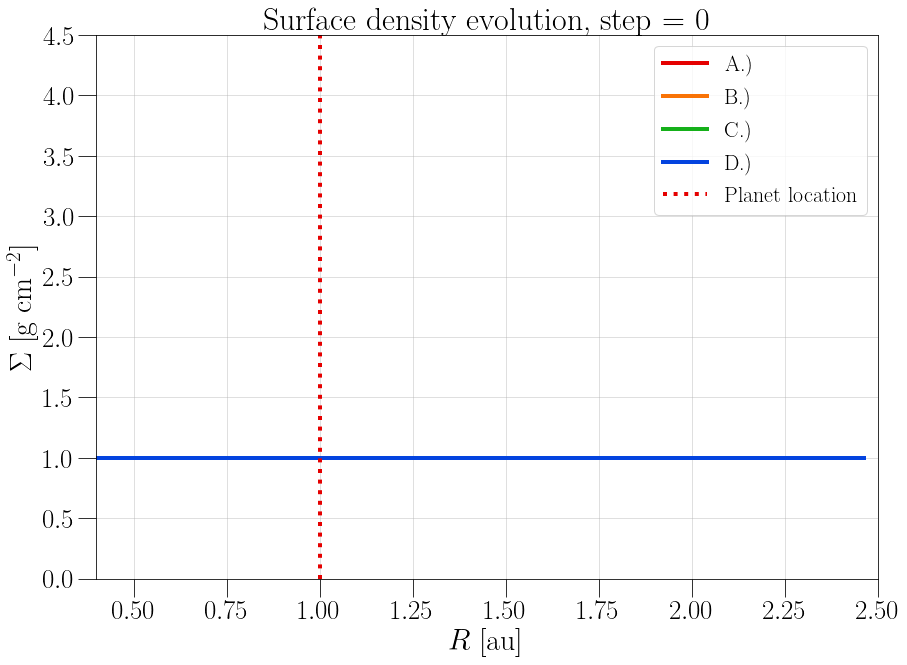

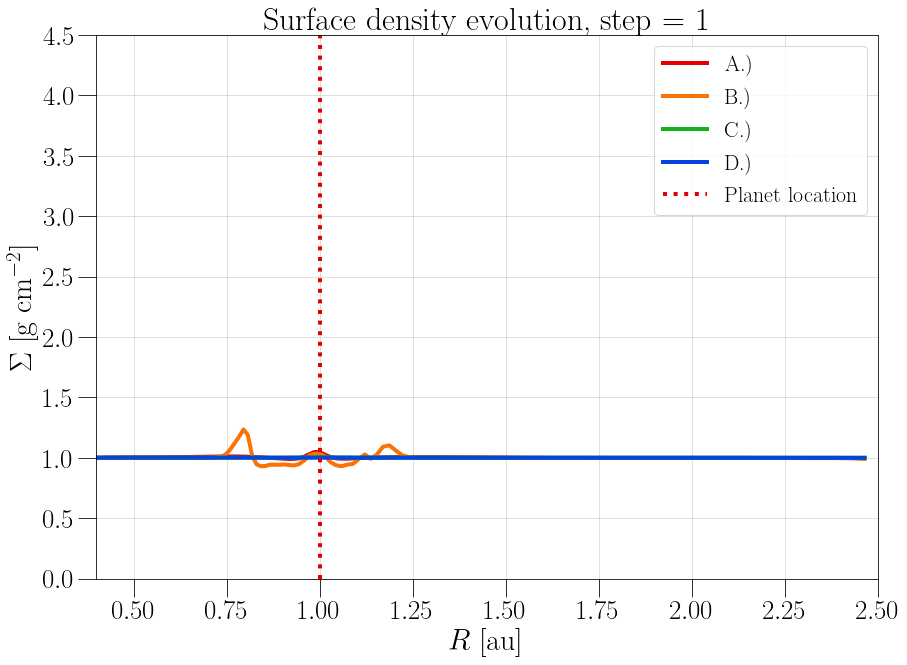

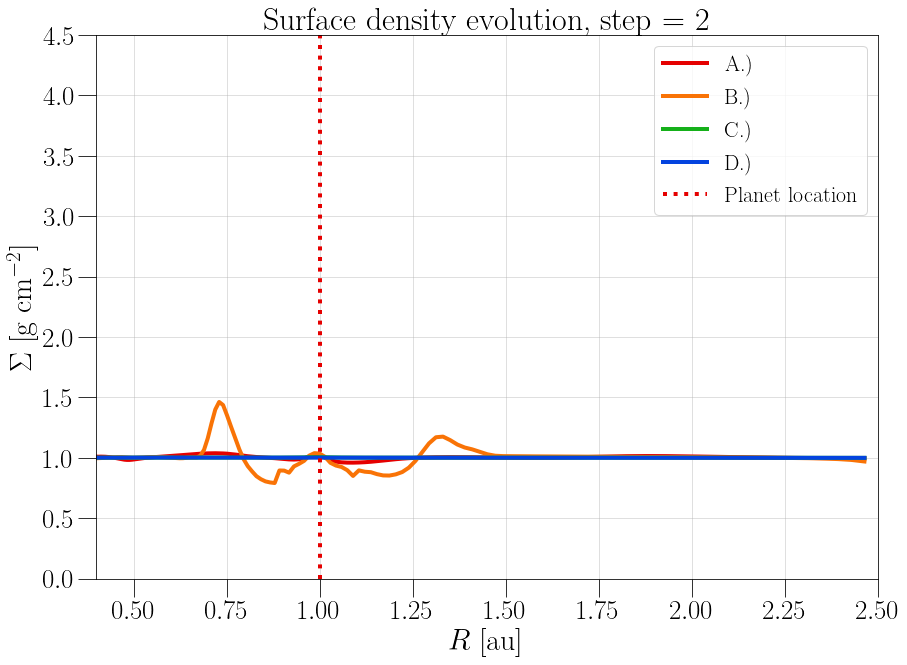

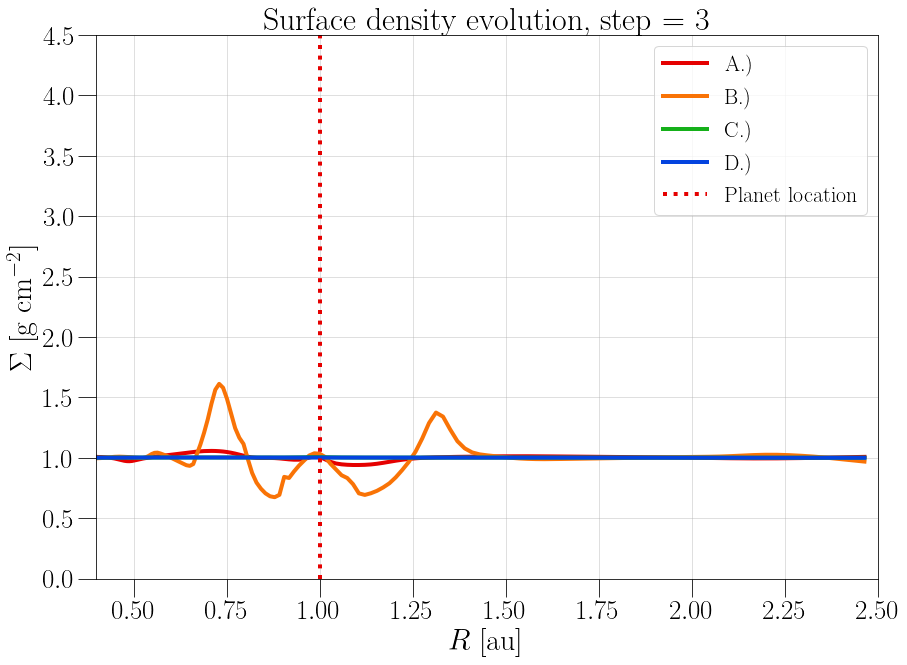

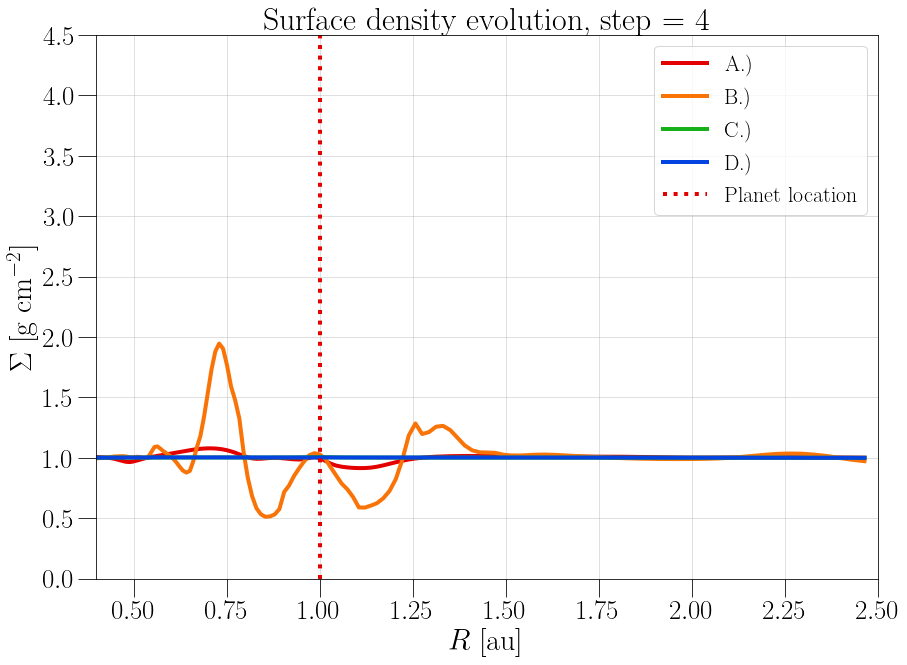

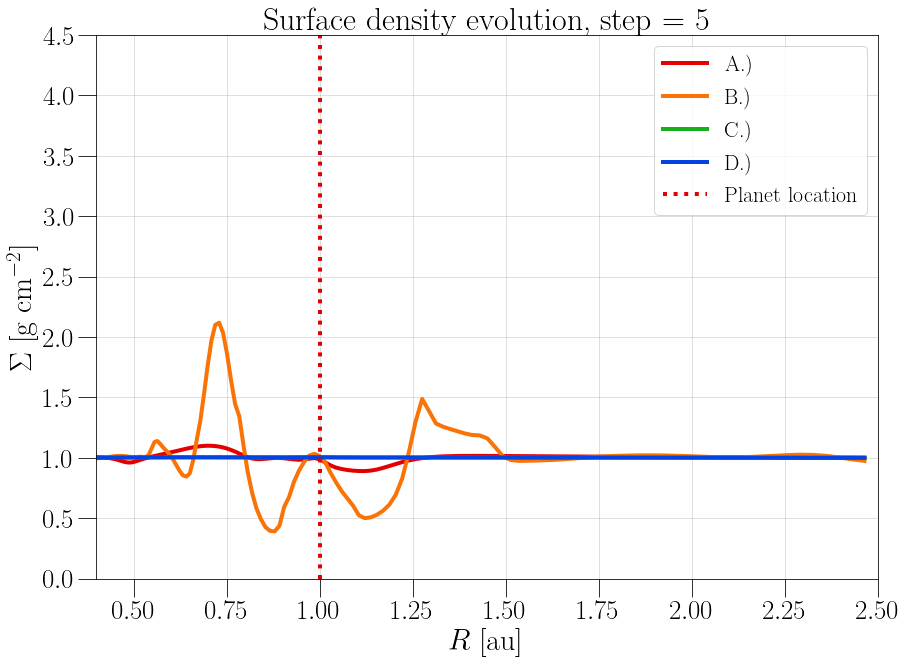

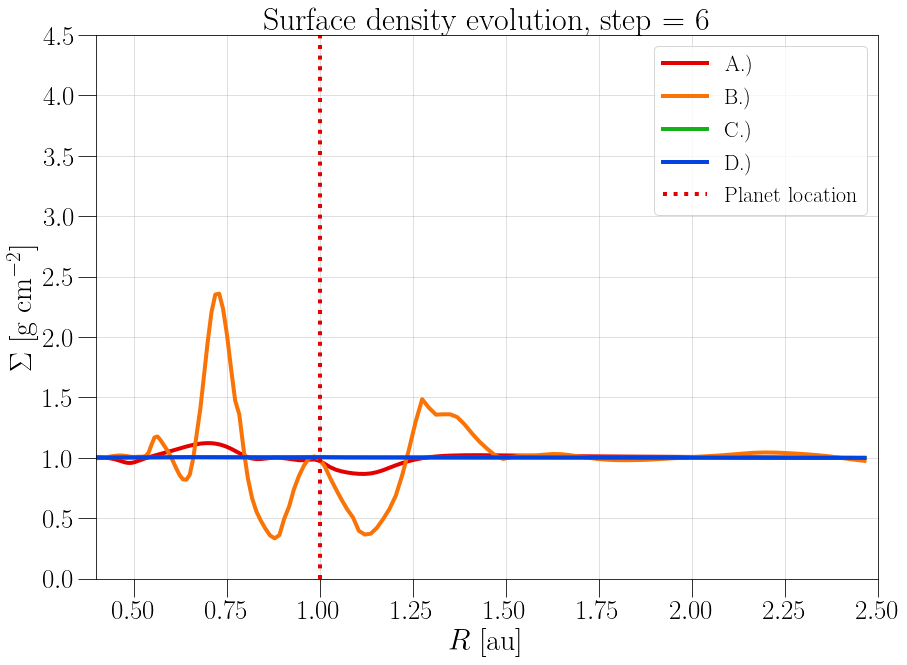

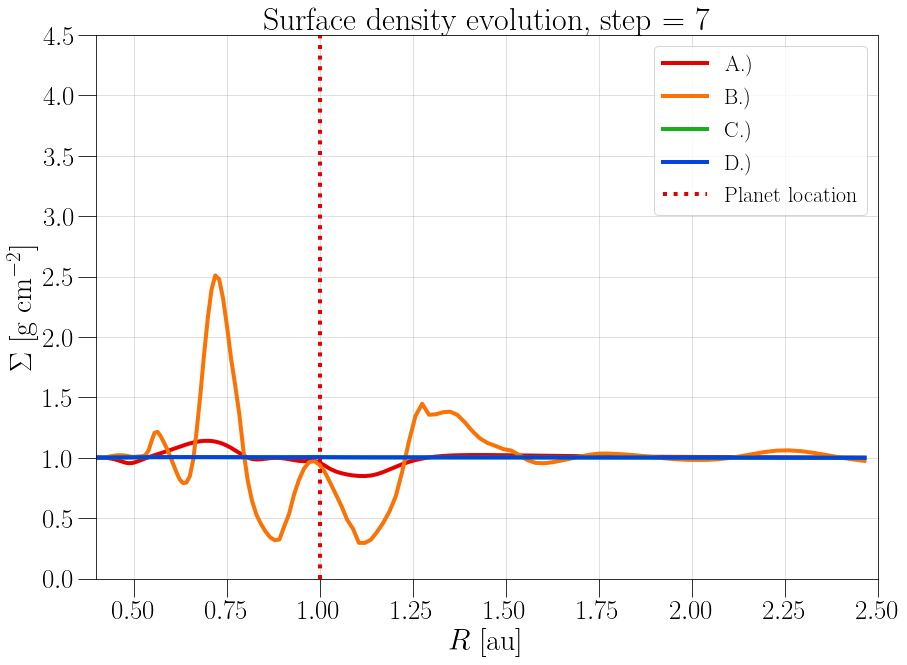

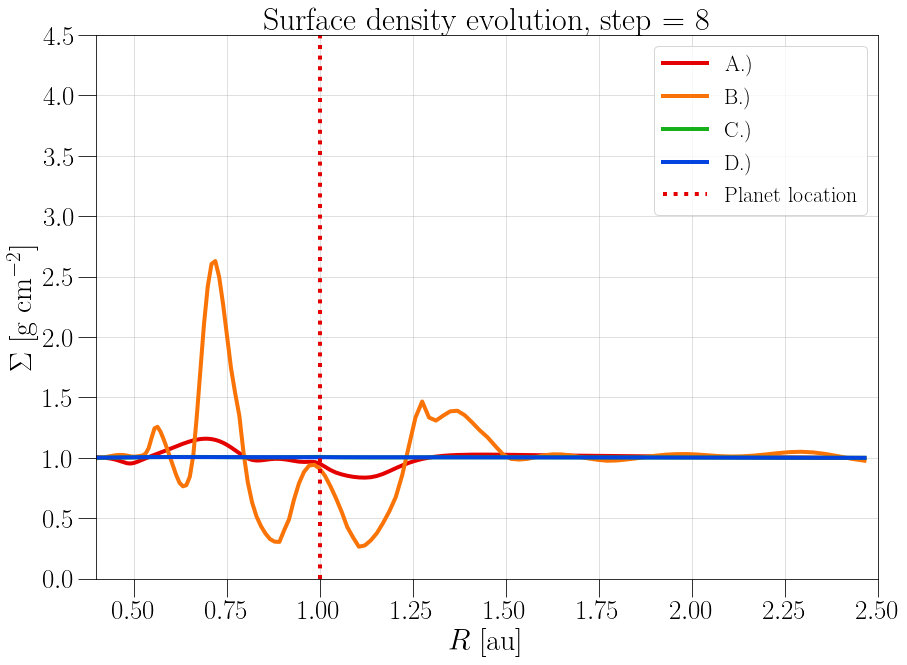

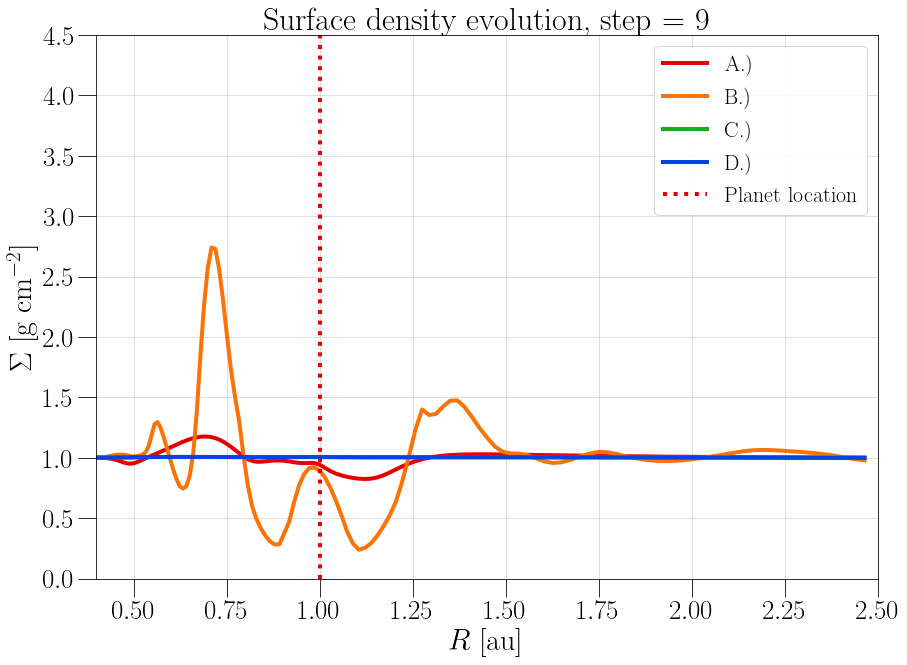

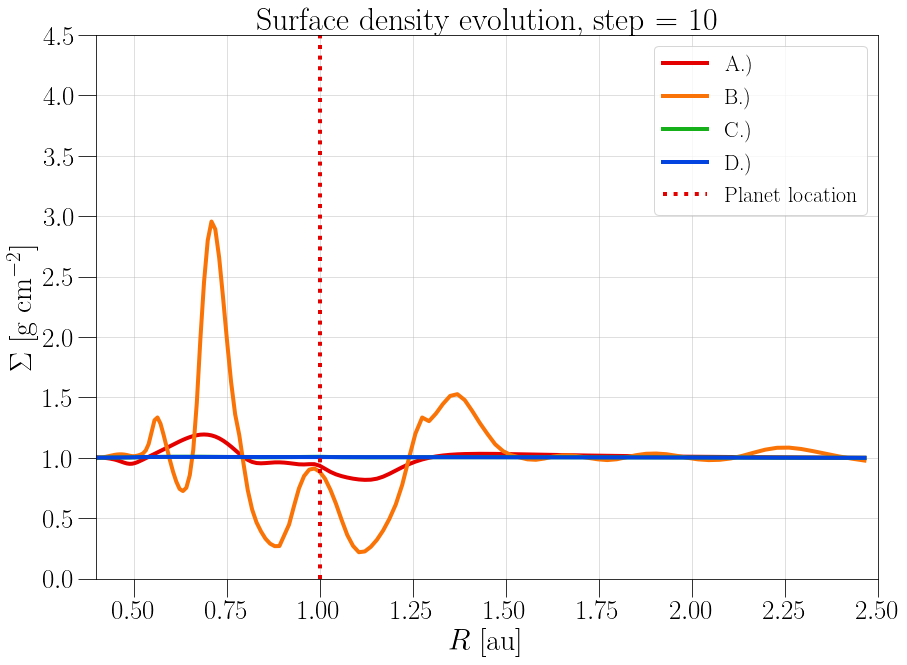

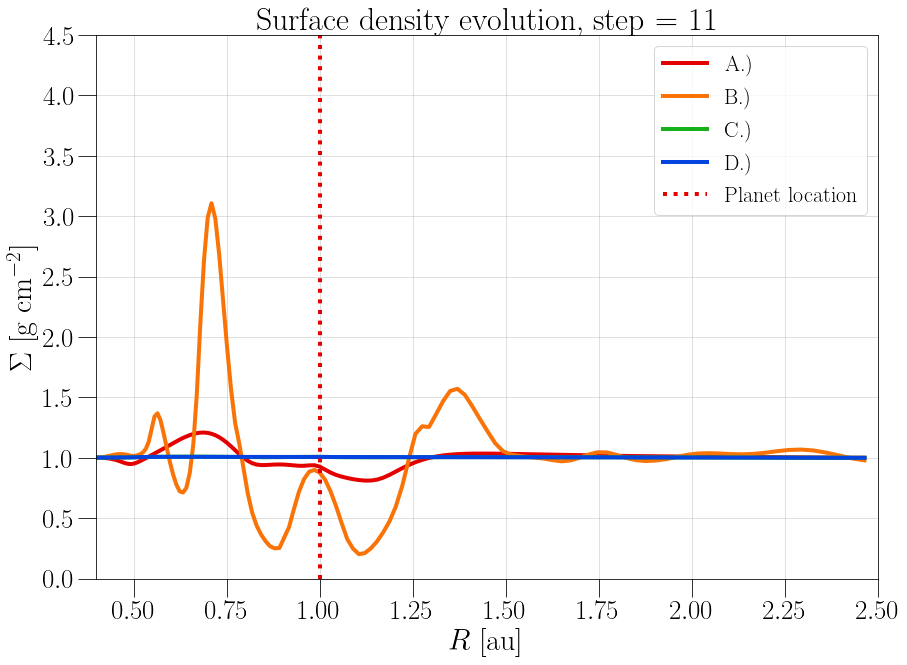

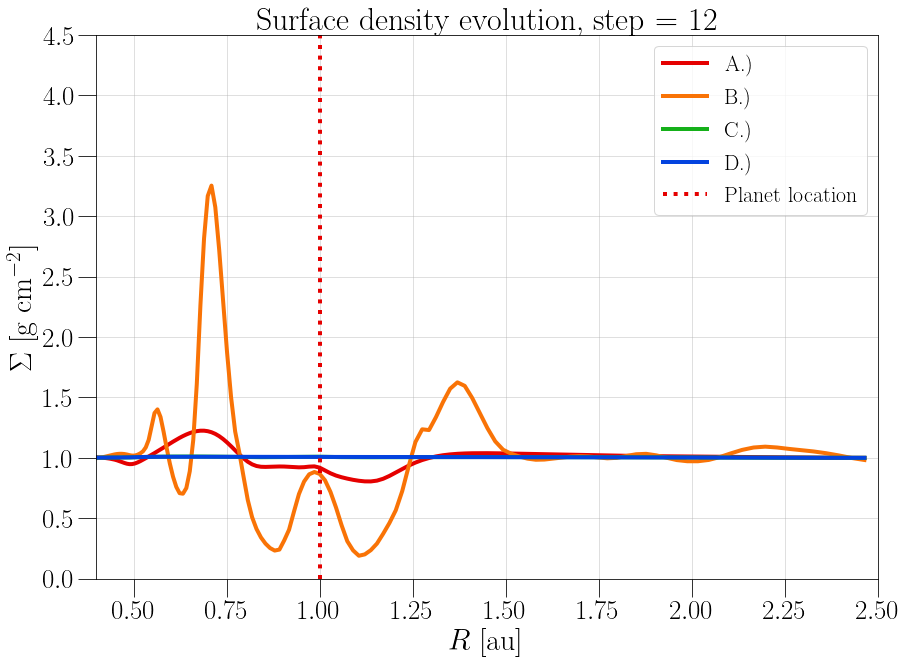

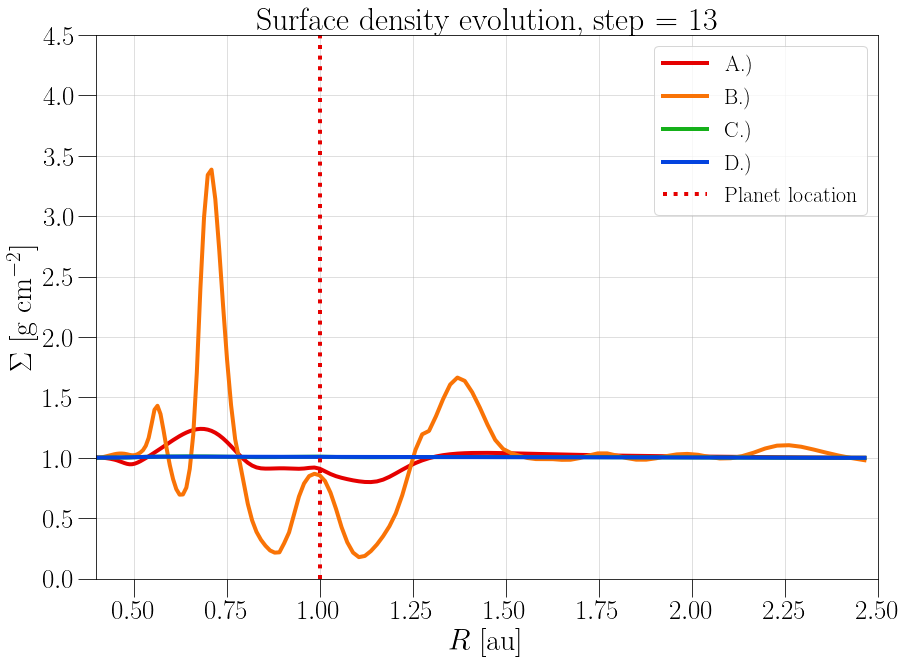

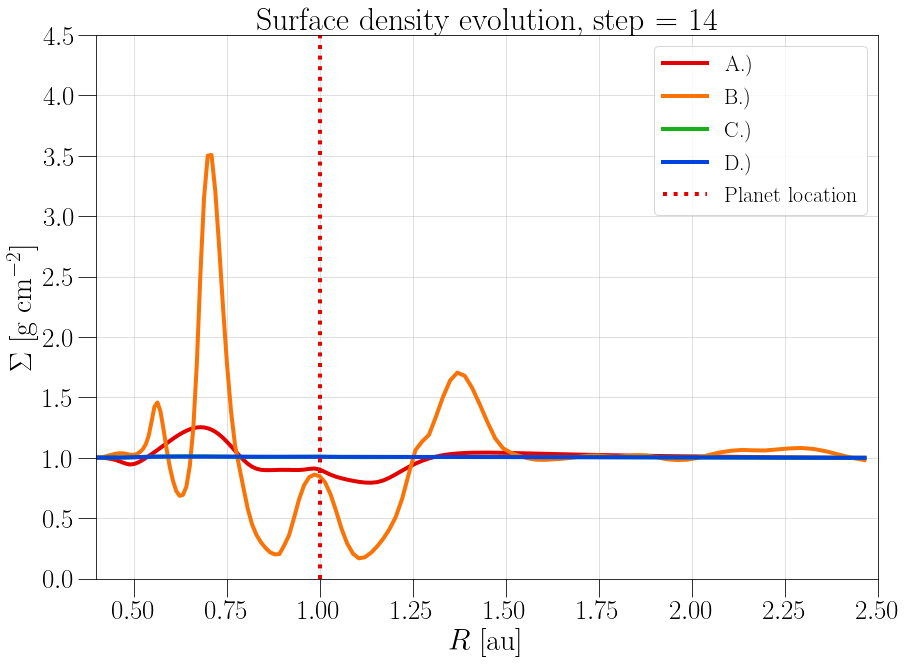

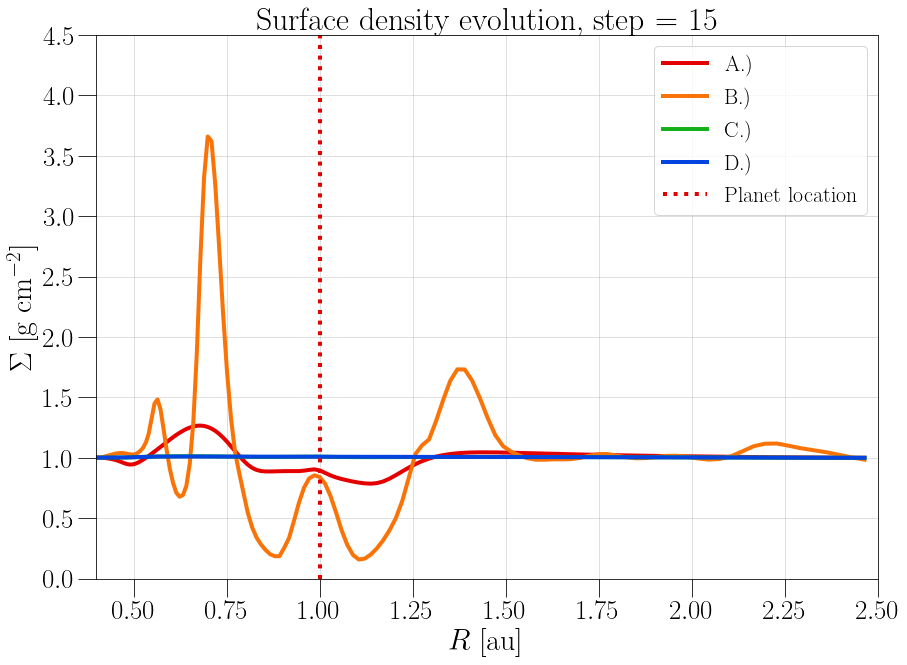

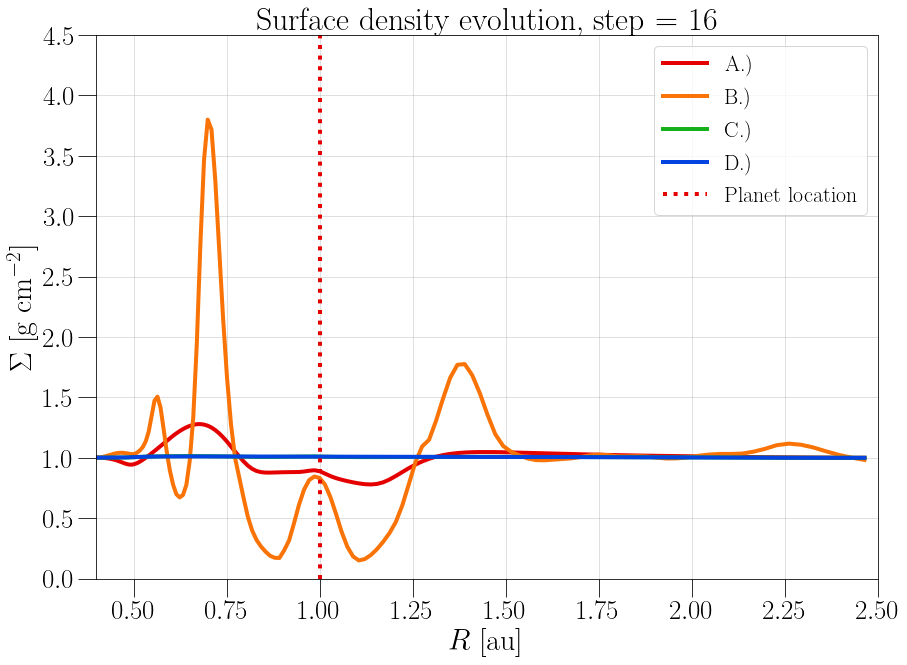

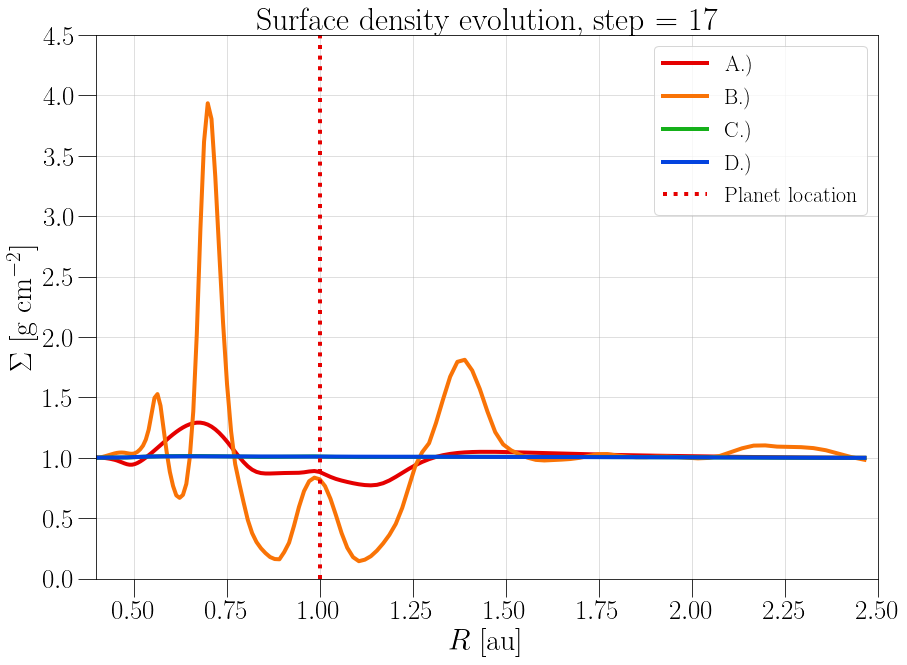

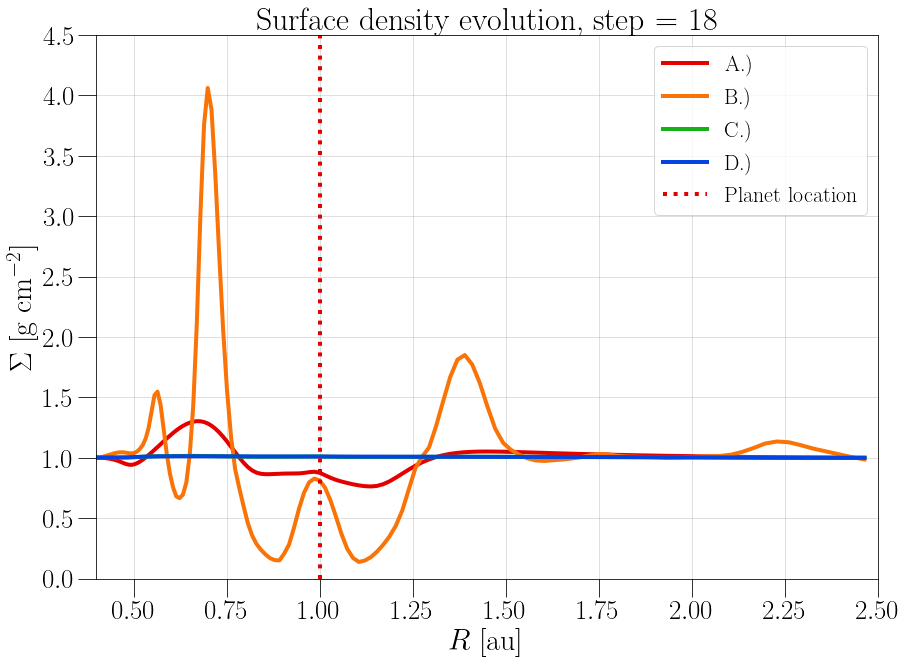

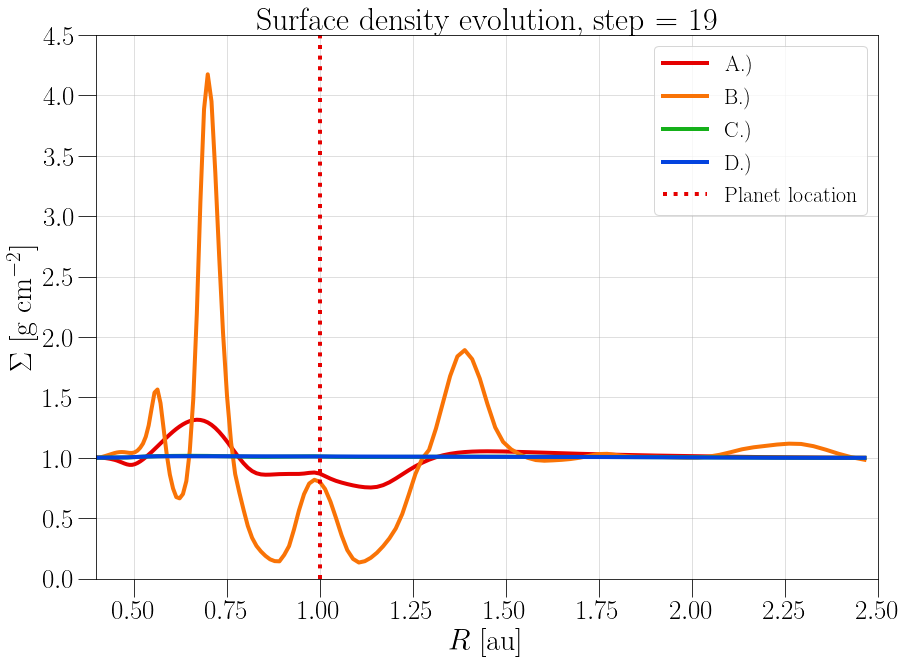

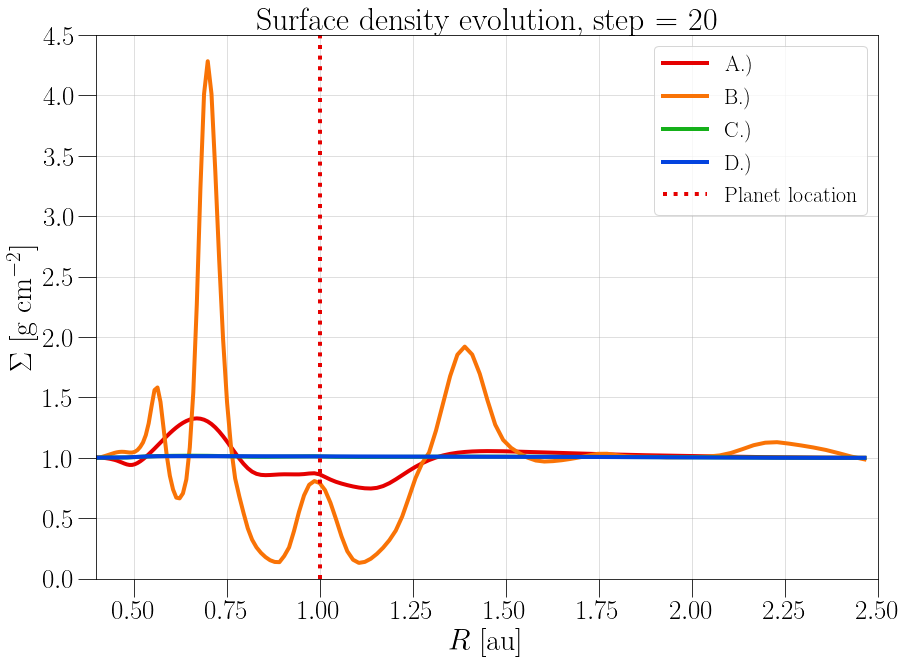

In [29]:
### SURF DENSITY
os.chdir(main_dir)

NAME_images = []

#fig = plt.figure(figsize = (14,10))
#ax0 = fig.add_subplot(111)
#ax0.grid(b=True, which='both')
#ax0.set_xlabel(r'$R$ [au]')
#ax0.set_ylabel(r'$\Sigma$ [g cm$^{-2}$]')
#ax0.set_ylim(0.7,1.4)
#ax0.set_xlim(0.4,2.5)
#ax0.set_xscale('log')
#ax0.set_yscale('log')

rad = np.zeros([len(folder_list),len(x_pos)])
for bx in range(len(folder_list)):
    rad[bx,:] = x_pos

#for bx, folder in enumerate(folder_list):
for kx in range(len(vtk_files)):
    
    fig = plt.figure(figsize = (14,10))
    ax0 = fig.add_subplot(111)
    
    ax0.grid(b=True, which='both')
    ax0.set_xlabel(r'$R$ [au]')
    ax0.set_ylabel(r'$\Sigma$ [g cm$^{-2}$]')
    ax0.set_ylim(0.0,4.5)
    ax0.set_xlim(0.4,2.5)
    #ax0.set_xscale('log')
    #ax0.set_yscale('log')
    
    ax0.plot(rad[0,:],surf_dens[0,kx,:],color='xkcd:red',linestyle='-',linewidth=4,label='A.)')
    ax0.plot(rad[0,:],surf_dens[1,kx,:],color='xkcd:orange',linestyle='-',linewidth=4,label='B.)')
    ax0.plot(rad[0,:],surf_dens[2,kx,:],color='xkcd:green',linestyle='-',linewidth=4,label='C.)')
    ax0.plot(rad[0,:],surf_dens[3,kx,:],color='xkcd:blue',linestyle='-',linewidth=4,label='D.)')
    
    #if kx == 0:
    #    ax0.plot(rad[0,:],rad[0,:]*-1,color='xkcd:red',linestyle='-',linewidth=4,label='surf dens')
    #    ax0.plot(rad[0,:],rad[0,:]*-1,color='xkcd:green',linestyle='-',linewidth=4,label='surf dens')
    #    ax0.plot(rad[0,:],rad[0,:]*-1,color='xkcd:blue',linestyle='-',linewidth=4,label='surf dens')
    #    ax0.plot(rad[0,:],rad[0,:]*-1,color='xkcd:violet',linestyle='-',linewidth=4,label='surf dens')
    
    ax0.axvline(x = 1.0,color='xkcd:red',linestyle=':',linewidth=4,label='Planet location')
    ax0.legend(loc='upper right')
    
    ax0.set_title(r'Surface density evolution, step = %d' %kx)
    
    NAME_images.append('surf_dens_{}.png'.format(kx+1)) # Name of image
    plt.savefig(NAME_images[-1])
    #ax0.clear()
    #print(NAME_images[-1])
    #plt.close()
    
os.chdir(main_dir)

In [ ]:
for kx in range(len(vtk_files)):
    print(surf_dens[:,kx,:])

In [12]:
rad[0,:]

array([0.4  , 0.406, 0.412, 0.418, 0.424, 0.43 , 0.436, 0.442, 0.449,
       0.455, 0.462, 0.468, 0.475, 0.482, 0.489, 0.496, 0.503, 0.51 ,
       0.518, 0.525, 0.533, 0.54 , 0.548, 0.556, 0.564, 0.572, 0.58 ,
       0.589, 0.597, 0.606, 0.615, 0.623, 0.632, 0.642, 0.651, 0.66 ,
       0.67 , 0.679, 0.689, 0.699, 0.709, 0.719, 0.73 , 0.74 , 0.751,
       0.762, 0.773, 0.784, 0.795, 0.807, 0.818, 0.83 , 0.842, 0.854,
       0.867, 0.879, 0.892, 0.905, 0.918, 0.931, 0.944, 0.958, 0.972,
       0.986, 1.   , 1.014, 1.029, 1.044, 1.059, 1.074, 1.09 , 1.105,
       1.121, 1.138, 1.154, 1.171, 1.187, 1.205, 1.222, 1.24 , 1.257,
       1.276, 1.294, 1.313, 1.332, 1.351, 1.37 , 1.39 , 1.41 , 1.43 ,
       1.451, 1.472, 1.493, 1.515, 1.537, 1.559, 1.581, 1.604, 1.627,
       1.651, 1.674, 1.698, 1.723, 1.748, 1.773, 1.799, 1.825, 1.851,
       1.878, 1.905, 1.932, 1.96 , 1.988, 2.017, 2.046, 2.075, 2.105,
       2.136, 2.167, 2.198, 2.229, 2.262, 2.294, 2.327, 2.361, 2.395,
       2.429, 2.464]

In [ ]:
### SURF DENSITY

In [ ]:
os.chdir(folder)

NAME_images = []

for kx in range(len(vtk_files)):

    fig = plt.figure(figsize = (14,10))
    ax0 = fig.add_subplot(111)
    ax0.grid(b=True, which='both')
    ax0.set_xlabel(r'$R$ [au]')
    ax0.set_ylabel(r'$\Sigma$ [g cm$^{-2}$]')
    ax0.set_ylim(0.7,1.4)
    ax0.set_xlim(0.4,2.5)
    #ax0.set_xscale('log')
    #ax0.set_yscale('log')
    
    ax0.plot(x_pos,surf_dens[kx],color='xkcd:blue',linestyle='-',linewidth=4,label='surf dens')
    ax0.axvline(x = 1.0,color='xkcd:red',linestyle=':',linewidth=4,label='planet loc')
    ax0.legend(loc='upper right')
    
    ax0.set_title(r'Surface density evolution, step = %d' %kx)
    
    NAME_images.append('surf_dens_{}.png'.format(kx+1)) # Name of image
    plt.savefig(NAME_images[-1])
    #print(NAME_images[-1])
    plt.close()

In [ ]:
# Create film with PNGs
video_name = 'surf_dens_evo.avi'

images = []
images = NAME_images
print(images)

frame = cv2.imread(os.path.join(images[0]))
height, width, layers = frame.shape

fps = 1
video = cv2.VideoWriter(video_name, 0, fps, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image)))

cv2.destroyAllWindows()
video.release()

In [ ]:
os.chdir(main_dir)

In [ ]:
y_pos.size

In [ ]:
### RHO DENSITY

In [ ]:
#rho

In [ ]:
#y_faces

In [ ]:
os.chdir(folder)
NAME_images = []

for kx in range(len(vtk_files)):

    fig = plt.figure(figsize = (14,10))
    ax0 = fig.add_subplot(111)
    #ax0.grid(b=True, which='both')
    #ax0.set_xlabel(r'$R$ [au]')
    #ax0.set_ylabel(r'$\Sigma$ [g cm$^{-2}$]')
    #ax0.set_ylim(0.7,1.4)
    #ax0.set_xlim(0.4,2.5)
    #ax0.set_xscale('log')
    #ax0.set_yscale('log')
    
    #c = ax0.pcolormesh(x_pos, y_pos, rho, cmap='RdBu')
    #c = ax0.pcolormesh(rho, cmap='RdBu')
    ax0.set_title(r'Surface density evolution, step = %d' %kx)
    #ax0.plot(x_pos,surf_dens[kx],color='xkcd:blue',linestyle='-',linewidth=4,label='surf dens')
    #ax0.axvline(x = 1.0,color='xkcd:red',linestyle=':',linewidth=4,label='planet loc')
    #fig.colorbar(c,ax=ax0)
    ax0.contourf(x_pos, y_pos, rho[kx])
    ax0.legend(loc='upper right')
    
    
    NAME_images.append('rho_{}.png'.format(kx+1)) # Name of image
    plt.savefig(NAME_images[-1])
    #print(NAME_images[-1])
    plt.close()

In [ ]:
os.chdir(main_dir)

In [ ]:
### Animation from any slides

In [ ]:
# Create film with PNGs
main_dir = "C:\\Users\\USER\\Dropbox\\UNLV\\LittlePrograms\\"
os.chdir(main_dir)
folder = "athena_planet-master\\Animations\\Std values\\"
NAME_images = []

all_files = os.listdir(folder)

NAME_images = fnmatch.filter(all_files, '*.jpeg')


video_name = 'standard.avi'

images = []
images = NAME_images
print(images)

os.chdir(folder)

frame = cv2.imread(os.path.join(images[0]))
height, width, layers = frame.shape

fps = 5
video = cv2.VideoWriter(video_name, 0, fps, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image)))

cv2.destroyAllWindows()
video.release()

In [ ]:
# Resolution changes

In [ ]:
# Resolution 1

rin = 0.4
rout = 2.5

Ntheta = 384
Nr = 128

x1rat = (rout/rin)**(1/Nr)

print('Nr = {}'.format(Nr))
print('x1rat = {}'.format(x1rat))
print('Nr = {}'.format(Ntheta))

In [ ]:
# Resolution 2

rin = 0.4
rout = 2.5

Ntheta = 384*2
Nr = 128*2

x1rat = (rout/rin)**(1/Nr)

print('Nr = {}'.format(Nr))
print('x1rat = {}'.format(x1rat))
print('Nr = {}'.format(Ntheta))

In [ ]:
# Resolution 5

rin = 0.4
rout = 2.5

Ntheta = 384*5
Nr = 128*5

x1rat = (rout/rin)**(1/Nr)

print('Nr = {}'.format(Nr))
print('x1rat = {}'.format(x1rat))
print('Nr = {}'.format(Ntheta))

In [ ]:
##### JOINING BLOCK VTK FILES ######
main_dir = "C:\\Users\\USER\\Dropbox\\UNLV\\LittlePrograms\\"
os.chdir(main_dir)
folder = "athena_planet-master\\taurus\\new_moon_res_5\\"
#os.chdir(folder)

all_files = os.listdir(folder)
vtk_files = fnmatch.filter(all_files, '*.vtk')
block_num = 25

NAME_output = vtk_files[0:101]
NAME_begin = vtk_files[0:101]
NAME_blocks = []

for ix in range(len(NAME_output)):
    NAME_output[ix] = NAME_output[ix].replace(".block0","")

#for jx in range(block_num):
#    NAME_blocks.append(vtk_files[jx*101])
    #NAME_blocks[-1]
#for ix in range(len(NAME_begin)):
for ix in range(1):    
    args = [NAME_output[ix]]
    for jx in range(block_num):
        #print(NAME_begin[ix].replace(".block0",".block%d"%jx))
        args.append(NAME_begin[ix].replace(".block0",".block%d"%jx))
    p = subprocess.Popen([main_dir+folder+"join_vtk++.exe"]+["-o"]+args, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, errors = p.communicate()
    print(ix)

In [ ]:
errors

In [ ]:
output

In [ ]:
NAME_output

In [ ]:
vtk_files